In [1]:
import scipy.io as sp_io
import scipy.integrate as sp_int
import importlib
import torus
from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import pandas as pd
import constants as const
import astropy.units as u
import astropy.constants as c
import stellar_spectra as ss
from p_winds import tools, parker, hydrogen, helium, transit, lines
from flatstar import draw

 ChiantiPy version 0.15.0 
 found PyQt5 widgets
 using PyQt5 widgets


In [2]:
#constants 

mp = 1.67e-24
k_b = 1.3807e-16
m_e = 9.11e-28
e = 4.803e-10
G = 6.67e-8

In [3]:
#solar element ratio

solar_abundance = pd.read_excel('../SolarSystemAbundances_Lodders2021.xlsx', usecols = [1, 11], names = ['Element', 'Abundance'], skiprows=3, dtype={'Element':'string'}) #in astronomical abundance

#change to abundance relative to hydrogen
solar_abundance['Abundance'] = 10**(solar_abundance['Abundance'] - 12)
sa = dict(zip(solar_abundance['Element'], solar_abundance['Abundance']))
sola =  {k.lower(): v for k, v in sa.items()}

#change metallicity


In [4]:
#WASP12 parameters
P = 1.5 * const.day

WASP12b = {'mass_s': const.m_sun, 'radius_s': const.r_sun, 
           'mass_p':1.46*const.m_jupiter, 'radius_p':1.884*const.r_jupiter, 'inclination': np.pi/2}

a = (P**2 * const.G * WASP12b['mass_s'] / 4 / np.pi**2)**(1/3)
WASP12b['semimajoraxis']= a
a_div_Rs = WASP12b['semimajoraxis'] / WASP12b['radius_s']

In [5]:
WASP12b_species_keys=['h', 'he', 'c', 'mg', 'ca']
WASP12b_species = dict((k, sola[k]) for k in WASP12b_species_keys)

In [6]:
units = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
spectrum = tools.make_spectrum_from_file('star_spectra/p-winds_ref_spec/solar_spectrum_scaled_lambda.dat',
                                    units)

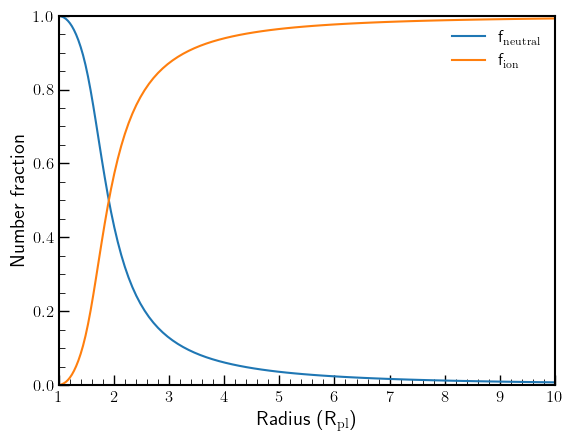

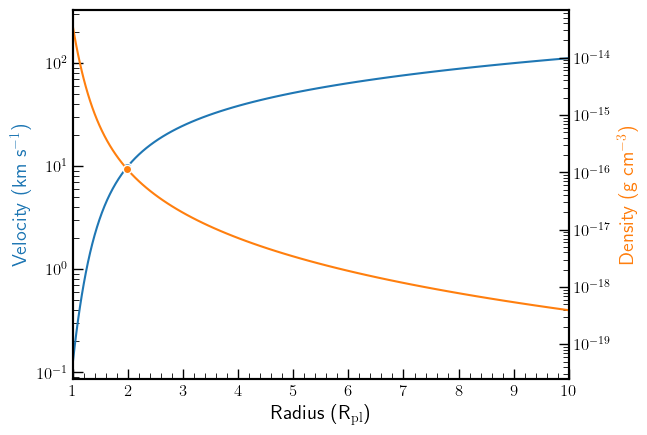

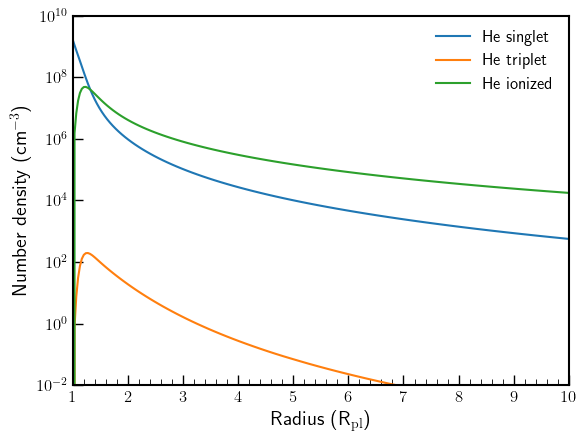

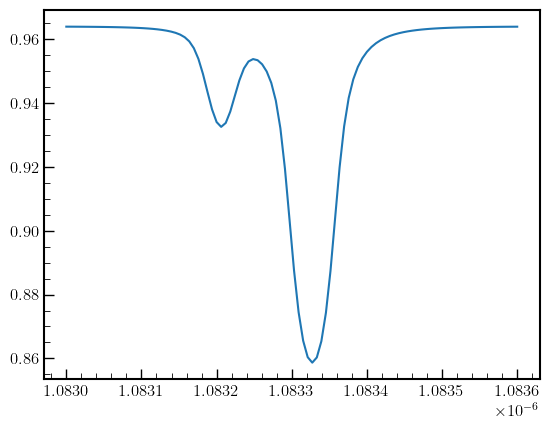

In [7]:
#make p-winds transit

#parameters in cm
parameters = WASP12b

#pwinds parameters -planet in jupiter units, star in solar units
b=parameters['semimajoraxis'] * np.cos(parameters['inclination']) / parameters['radius_s']
pwinds_parameters={'mass_s':parameters['mass_s']/const.m_sun, 'radius_s':parameters['radius_s']/const.r_sun,
                   'mass_p':parameters['mass_p']/const.m_jupiter, 'radius_p':parameters['radius_p']/const.r_jupiter, 
                   'semimajoraxis':parameters['semimajoraxis']/1.5e13, 'impact_parameter': b}

#wind parameters
wind_parameters={'mdot_p' : 10**12, 'T': 8000, 'h_fraction' : 0.9, 'mu_0' : 1.3} 

##late F star spectrum 
Fstar = ss.stellar_spectra('solar', semi_major_axis=parameters['semimajoraxis']/parameters['radius_s'], stellar_radius=pwinds_parameters['radius_s'], Lbol=1)
units1 = [u.angstrom, u.erg / u.s / u.cm ** 2 / u.angstrom, 1 /u.s, u.erg /u.cm**2] 
units2 = {'wavelength': u.angstrom, 'flux': u.erg / u.s / u.cm ** 2 / u.angstrom}
Fstar_spectrum = Fstar.get_spectrum(units=units1)
spectrum={'wavelength':Fstar_spectrum['wl'], 'flux_lambda':Fstar_spectrum['F_wl'], 'wavelength_unit':units1[0], 'flux_unit':units1[1]}

#spectrum = tools.make_spectrum_from_file('star_spectra/p-winds_ref_spec/solar_spectrum_scaled_lambda.dat',
                                    #units)

initial_f_ion = 0.0
r = np.logspace(0, np.log10(20), 100)  # Radial distance profile in unit of planetary radii

f_r, mu_bar,rates = hydrogen.ion_fraction(r, pwinds_parameters['radius_p'], wind_parameters['T'], wind_parameters['h_fraction'],
                            wind_parameters['mdot_p'], pwinds_parameters['mass_p'], wind_parameters['mu_0'], 
                            star_mass=pwinds_parameters['mass_s'], semimajor_axis=pwinds_parameters['semimajoraxis'],
                            spectrum_at_planet=spectrum, exact_phi=True,
                            initial_f_ion=initial_f_ion, relax_solution=True,
                            return_mu=True, return_rates=True)

f_ion = f_r
f_neutral = 1 - f_r

plt.plot(r, f_neutral, color='C0', label='f$_\mathrm{neutral}$')
plt.plot(r, f_ion, color='C1', label='f$_\mathrm{ion}$')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number fraction')
plt.xlim(1, 10)
plt.ylim(0, 1)
plt.legend()
plt.show()

vs = parker.sound_speed(wind_parameters['T'], mu_bar)  # Speed of sound (km/s, assumed to be constant)
rs = parker.radius_sonic_point_tidal(pwinds_parameters['mass_p'], vs, pwinds_parameters['mass_s'], pwinds_parameters['semimajoraxis'])  # Radius at the sonic point (jupiterRad)
rhos = parker.density_sonic_point(wind_parameters['mdot_p'], rs, vs)  # Density at the sonic point (g/cm^3)

r_array = r * pwinds_parameters['radius_p'] / rs
v_array, rho_array = parker.structure_tidal(r_array, vs, rs, pwinds_parameters['mass_p'], pwinds_parameters['mass_s'], pwinds_parameters['semimajoraxis'])

# Convenience arrays for the plots
r_plot = r_array * rs / pwinds_parameters['radius_p']
v_plot = v_array * vs
rho_plot = rho_array * rhos

# Finally plot the structure of the upper atmosphere
# The circles mark the velocity and density at the sonic point
ax1 = plt.subplot()
ax2 = ax1.twinx()
ax1.semilogy(r_plot, v_plot, color='C0')
ax1.plot(rs / pwinds_parameters['radius_p'], vs, marker='o', markeredgecolor='w', color='C0')
ax2.semilogy(r_plot, rho_plot, color='C1')
ax2.plot(rs / pwinds_parameters['radius_p'], rhos, marker='o', markeredgecolor='w', color='C1')
ax1.set_xlabel(r'Radius (R$_{\rm pl}$)')
ax1.set_ylabel(r'Velocity (km s$^{-1}$)', color='C0')
ax2.set_ylabel(r'Density (g cm$^{-3}$)', color='C1')
ax1.set_xlim(1, 10)
plt.show()


initial_state = np.array([1.0, 0.0])
f_he_1, f_he_3, reaction_rates = helium.population_fraction(
    r, v_array, rho_array, f_ion,
    pwinds_parameters['radius_p'], wind_parameters['T'], wind_parameters['h_fraction'], vs, rs, rhos, spectrum,
    initial_state=initial_state, relax_solution=True, return_rates=True)

m_h = c.m_p.to(u.g).value

# Number density of helium nuclei
he_fraction = 1 - wind_parameters['h_fraction']
n_he = (rho_array * rhos * he_fraction / (wind_parameters['h_fraction'] + 4 * he_fraction) / m_h)

n_he_1 = f_he_1 * n_he
n_he_3 = f_he_3 * n_he
n_he_ion = (1 - f_he_1 - f_he_3) * n_he

plt.semilogy(r, n_he_1, color='C0', label='He singlet')
plt.semilogy(r, n_he_3, color='C1', label='He triplet')
plt.semilogy(r, n_he_ion, color='C2', label='He ionized')
plt.xlabel(r'Radius (R$_\mathrm{pl}$)')
plt.ylabel('Number density (cm$^{-3}$)')
plt.xlim(1, 10)
plt.ylim(1E-2, 1E10)
plt.legend()
plt.show()

#switch to physcial units but for some reason SI!!
R_pl_physical = pwinds_parameters['radius_p'] * 71492000  # Planet radius in m
r_SI = r * R_pl_physical  # Array of altitudes in m
v_SI = v_array * vs * 1000  # Velocity of the outflow in m / s
n_he_3_SI = n_he_3 * 1E6  # Volumetric densities in 1 / m ** 3
planet_to_star_ratio = parameters['radius_p'] / parameters['radius_s']

# Set up the ray tracing. We will use a coarse 100-px grid size,
# but we use supersampling to avoid hard pixel edges.
flux_map, t_depth, r_from_planet = transit.draw_transit(
    planet_to_star_ratio,
    planet_physical_radius=R_pl_physical,
    impact_parameter=pwinds_parameters['impact_parameter'],
    phase=0.0,
    supersampling=10,
    grid_size=100)

#helium 23S -> 23P transition line properties
w0, w1, w2 = np.array([0.00010832058, 0.00010833217, 0.00010833307]) * 10**-2 #m
f0, f1, f2 = np.array([0.059902, 0.17974, 0.29958])
a_ij = 10216000.0
m_He = 4 * 1.67262192369e-27  # Helium atomic mass in kg



wl = np.linspace(1.0830, 1.0836, 100) * 1E-6  # Wavelengths in m
method = 'formal'

# Finally let's calculate the combined spectrum of all lines in the triplet
# To do that, we combine all the line properties in their respective arrays
w_array = np.array([w0, w1, w2])
f_array = np.array([f0, f1, f2])
a_array = np.array([a_ij, a_ij, a_ij])  # This is the same for all lines in then triplet
spectrum, tau = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wl, wind_parameters['T'], m_He, wind_broadening_method=method)

plt.plot(wl, spectrum)

In [27]:
#make torus going up in optical depth to EUV by factors of 10
flux_map_oot = draw.star(100, supersampling=10).intensity

flux_map_it, _, _ = transit.draw_transit(
        planet_to_star_ratio,
        planet_physical_radius=R_pl_physical,
        impact_parameter=0,
        phase=0,
        supersampling=10,
        grid_size=100)



r_linblad = 2**(2/3)*parameters['semimajoraxis']
w_linblad = 0.03*r_linblad
omega = np.sqrt(const.G * parameters['mass_s'] / parameters['semimajoraxis']**3) 
Rtorus = [parameters['semimajoraxis'], parameters['semimajoraxis'] + 3e6 / (2 * omega)] 
Rtorus2 = [r_linblad - w_linblad, r_linblad + w_linblad]
Fstar_spectrum2 = Fstar.get_spectrum() 

WASP12b0p01 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus, i = np.pi/2, tau=0.01)

i_he30p01oot, tau_he30p01oot = WASP12b0p01.do_transit('he_1', ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot)
i_he30p01it, tau_he30p01it = WASP12b0p01.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_it)
i_tot_he30p01it = np.einsum('ij, ijk -> k',flux_map_it, np.exp(-(tau_he30p01it + tau)))

WASP12b0p1 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus, i = np.pi/2, tau=0.1)

i_he30p1oot, tau_he30p1oot = WASP12b0p1.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot)
i_he30p1it, tau_he30p1it = WASP12b0p1.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_it)
i_tot_he30p1it = np.einsum('ij, ijk -> k',flux_map_it, np.exp(-(tau_he30p1it + tau)))

WASP12b1 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus, i = np.pi/2, tau=1)

i_he31oot, tau_he31oot = WASP12b1.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot)
i_he31it, tau_he31it = WASP12b1.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_it)
i_tot_he31it = np.einsum('ij, ijk -> k',flux_map_it, np.exp(-(tau_he31it + tau)))

WASP12b10 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus, i = np.pi/2, tau=10)
WASP12b102 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus2, i = np.pi/2, tau=1000)

i_he310oot, tau_he310oot = WASP12b10.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot)
i_he310it, tau_he310it = WASP12b10.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_it)
i_tot_he310it = np.einsum('ij, ijk -> k',flux_map_it, np.exp(-(tau_he310it + tau)))

WASP12b100 = torus.Torus(species = WASP12b_species, stellar_spectrum = Fstar_spectrum2, Ms = parameters['mass_s'], Rs = parameters['radius_s'], ap = parameters['semimajoraxis'], T = np.float64(10**4), Rtorus=Rtorus, i = np.pi/2, tau=100)

i_he3100oot, tau_he3100oot = WASP12b100.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_oot)
i_he3100it, tau_he3100it = WASP12b100.do_transit('he_1',  ['he_3-2', 'he_3-1', 'he_3-0'], np.linspace(1.0830e-4, 1.0836e-4, 100), flux_map_it)
i_tot_he3100it = np.einsum('ij, ijk -> k', flux_map_it, np.exp(-(tau_he3100it + tau)))

In [90]:
WASP12b10.calculate_tau_species('h_1')[0]*10**-6

array([0.12462203, 0.0624236 , 0.01990145, 0.00998864, 0.00695528,
       0.00346865, 0.00326458, 0.00163229, 0.        ])

Text(0, 0.5, 'flux out - flux in')

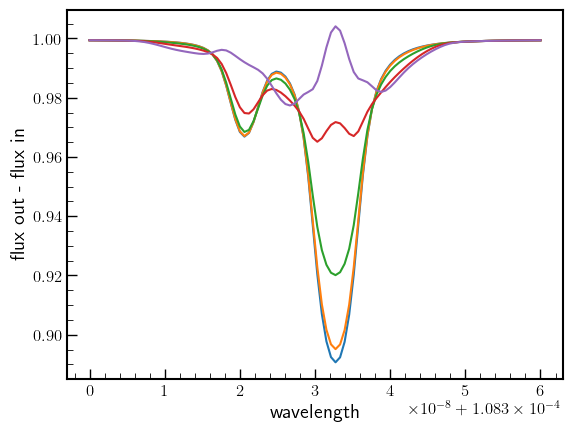

In [20]:
#flux in/flux out

td_opt = planet_to_star_ratio**2
tm_opt = 1 - planet_to_star_ratio**2

plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he30p01it / i_he30p01oot / tm_opt)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he30p1it / i_he30p1oot / tm_opt)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he31it / i_he31oot / tm_opt)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he310it / i_he310oot / tm_opt)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), i_tot_he3100it /  i_he3100oot / tm_opt)

plt.xlabel('wavelength')
plt.ylabel('flux out - flux in')


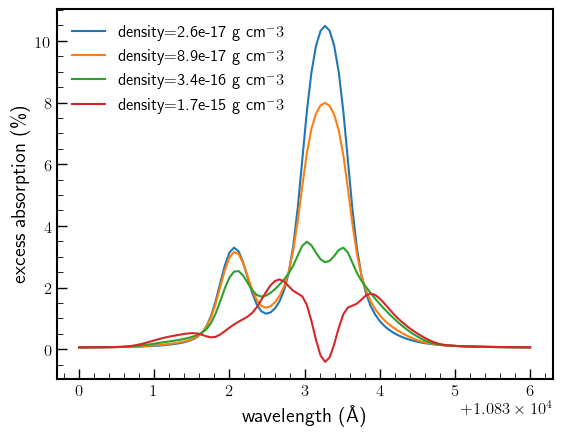

In [54]:
def excess_absorption(Fin, Fout, td):

    return (1 - (Fin / (Fout - Fout * td)))*100

wav = np.linspace(1.0830e-4, 1.0836e-4, 100) * 1e8
#plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), excess_absorption(i_tot_he30p01it, i_he30p01oot, td_opt))
plt.plot(wav, excess_absorption(i_tot_he30p1it, i_he30p1oot, td_opt), label=f'density={WASP12b0p1.nH * const.mp:.2g} g cm$^{-3}$')
plt.plot(wav, excess_absorption(i_tot_he31it, i_he31oot, td_opt), label=f'density={WASP12b1.nH * const.mp:.2g} g cm$^{-3}$')
plt.plot(wav, excess_absorption(i_tot_he310it, i_he310oot, td_opt), label=f'density={WASP12b10.nH * const.mp:.2g} g cm$^{-3}$')
plt.plot(wav, excess_absorption(i_tot_he3100it, i_he3100oot, td_opt), label=f'density={WASP12b100.nH * const.mp:.2g} g cm$^{-3}$')

plt.xlabel(r'wavelength (\AA)')
plt.ylabel('excess absorption (\%)')
plt.legend()

plt.savefig('paper_plots/excess_absorption2.pdf', bbox_inches = 'tight')

Text(0, 0.5, 'flux out - flux in')

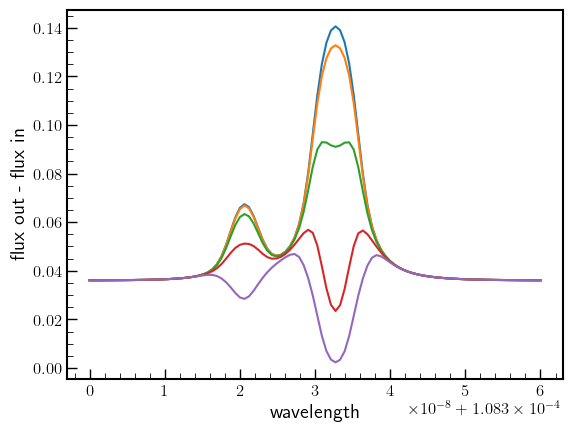

In [11]:
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), -i_tot_he30p01it + i_he30p01oot)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), -i_tot_he30p1it + i_he30p1oot)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), -i_tot_he31it + i_he31oot)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), -i_tot_he310it + i_he310oot)
plt.plot(np.linspace(1.0830e-4, 1.0836e-4, 100), -i_tot_he3100it + i_he3100oot)

plt.xlabel('wavelength')
plt.ylabel('flux out - flux in')

#plt.savefig('paper_plots/.pdf', bbox_inches='tight')



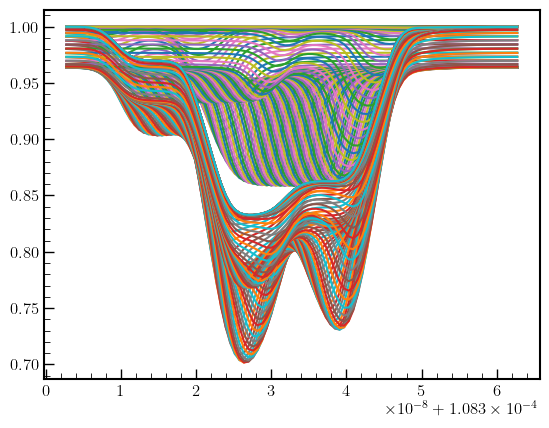

In [28]:
##transit as a function of time

#central wavelength 
wav1, wav2 = 0.00010833217, 0.00010833307
f1, f2 = 0.17974, 0.29958
wavc = (f1*wav1 + f2*wav2) / (f1 + f2)

#phase
phase = np.linspace(-0.65, 0.65, 100)
omega = np.sqrt(const.G * parameters['mass_s'] / parameters['semimajoraxis']**3)
phase_at_star = np.arcsin(parameters['radius_s']/ parameters['semimajoraxis'])
planet_rv = omega * parameters['semimajoraxis'] * np.sin(phase * phase_at_star / 0.5) * 1e-2
wav = np.linspace(wavc - 3e-8, wavc + 3e-8, 100)
wav_SI = wav * 1e-2

#flux
Fin = np.zeros(100)
Fin2 = np.zeros(100)
Fp = np.zeros(100)

for i,p in enumerate(phase):

    flux_map, t_depth, r_from_planet = transit.draw_transit(
        planet_to_star_ratio,
        planet_physical_radius=R_pl_physical,
        impact_parameter=0,
        phase=p,
        supersampling=10,
        grid_size=100)
    
    intensity, tau_t = WASP12b10.do_transit('he_1', ['he_3-0', 'he_3-1', 'he_3-2'], wav, flux_map)
    intensity2, tau_t2 = WASP12b102.do_transit('he_1', ['he_3-0', 'he_3-1', 'he_3-2'], wav, flux_map)

    spectrum, tau_p = transit.radiative_transfer_2d(flux_map, r_from_planet,
                                        r_SI, n_he_3_SI, v_SI, w_array, f_array, a_array,
                                        wav_SI, wind_parameters['T'], m_He, planet_radial_velocity=planet_rv[i], wind_broadening_method=method)

    i_tot = np.einsum('ij, ijk -> k', flux_map, np.exp(-(tau_t + tau_p)))
    i_tot2 = np.einsum('ij, ijk -> k', flux_map, np.exp(-(tau_t2 + tau_p)))
    i_p = np.einsum('ij, ijk -> k', flux_map, np.exp(-tau_p))

    plt.plot(wav, spectrum)
    plt.plot(wav, i_tot);
      

    Fin[i] = sp_int.trapezoid(i_tot, x=wav)
    Fin2[i] = sp_int.trapezoid(i_tot2, x=wav)
    Fp[i] = sp_int.trapezoid(i_p, x=wav)

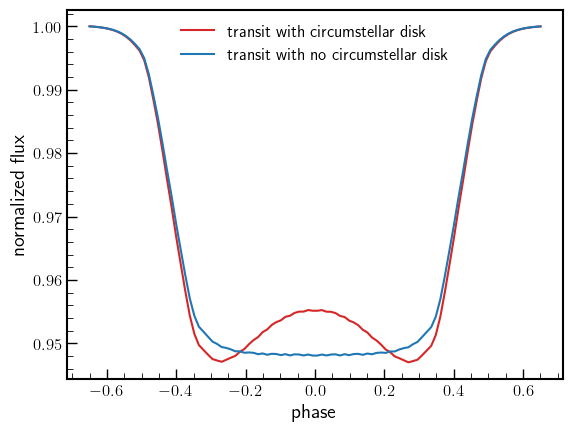

In [38]:
plt.plot(phase, Fin / Fin[0], color = 'tab:red', label='transit with circumstellar disk')
#plt.plot(phase, Fin2 / Fin2[0], 'blue')
plt.plot(phase, Fp / Fp[0], color = 'tab:blue', label='transit with no circumstellar disk')
plt.legend()
plt.ylabel('normalized flux')
plt.xlabel('phase')
plt.savefig('paper_plots/photometric_transit.pdf', bbox_inches='tight')


In [208]:
flux_map, t_depth, r_from_planet = transit.draw_transit(
        planet_to_star_ratio,
        planet_physical_radius=R_pl_physical,
        impact_parameter=0,
        phase=-0.5,
        supersampling=10,
        grid_size=100)

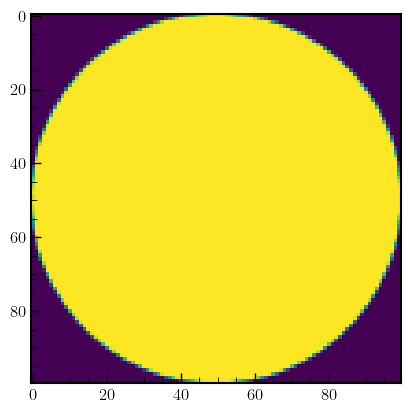

In [209]:
plt.imshow(flux_map)

In [ ]:
#get star spectra from fits 

def get_spectra(fits_file):
    spec = fits.getdata(fits_file,1)
    wav = spec['WAVELENGTH'] * 1e-8       #in angstroms so turn into cgs 
    irr_wav = spec['FLUX'] * 1e8          
    nu = const.c / wav
    irr_nu = irr_wav * wav**2 / const.c
    return {'wl' : wav, 'F_wl': irr_wav, 'nu' : nu, 'F_nu' : irr_nu}

K6 = get_spectra('hlsp_muscles_multi_multi_hd85512_broadband_v22_adapt-const-res-sed.fits')
K2 = get_spectra('hlsp_muscles_multi_multi_v-eps-eri_broadband_v22_adapt-const-res-sed.fits')
G5 = get_spectra('hlsp_muscles_multi_multi_wasp-127_broadband_v24_adapt-const-res-sed.fits')
F4 = get_spectra('hlsp_muscles_multi_multi_wasp-43_broadband_v24_adapt-const-res-sed.fits')

def normalize_spectrum(stellar_spectrum, Feuv, euv_range = [1e-6, 1.17e-5]):

    normalized_stellar_spectrum = deepcopy(stellar_spectrum)
    euv_mask = (stellar_spectrum['wl'] > euv_range[0]) & (stellar_spectrum['wl'] < euv_range[1])
    Feuv_ss = sp_int.trapezoid(stellar_spectrum['F_wl'][euv_mask], stellar_spectrum['wl'][euv_mask])
    normalized_stellar_spectrum['F_wl'] *= (Feuv / Feuv_ss)
    normalized_stellar_spectrum['F_nu'] *= (Feuv / Feuv_ss)
    
    return normalized_stellar_spectrum

normF4 = normalize_spectrum(F4, 10**4)

ss_idl = sp_io.readsav('ssi3_ext_0nm_1600nm.sav')
ss_wav = ss_idl['ssi3_ext'][0][0] #nm
ss_irr = ss_idl['ssi3_ext'][0][3][:, 1000] #mw/m^2/nm
ss_mod = ss_idl['ssi3_ext'][0][5][:, 1000] #mw/m^2/nm

#turn into cgs
ss_wav_cgs = ss_wav * 1e-7
ss_irr_cgs = ss_irr * 1e7
ss_nu_cgs = const.c / ss_wav_cgs
ss_irr_nu_cgs = ss_irr_cgs * ss_wav_cgs**2 / const.c

ss = {'wl' : ss_wav_cgs, 'F_wl' : ss_irr_cgs, 'nu' : ss_nu_cgs, 'F_nu' : ss_irr_nu_cgs}

norm_ss = normalize_spectrum(ss, 10**3)

In [7]:
lines.he_3_properties()[-1] / 1e7

1.0216

In [38]:
Ms=1.1712706217646202e+33
Rs=44921502365.62851
ap=277328096483.4596
T=10000.0
Rtorus=[114248732342.96628, 440407460623.9529]
i=1.5707963267948966
tau=0.1

flux_map_oot = draw.star(100, supersampling=10).intensity
wav = np.linspace(1.0830e-4, 1.0836e-4, 100)

base_spectrum = ss.stellar_spectra('late-K', semi_major_axis = ap / Rs) 
norm_spectrum = base_spectrum.get_spectrum()     


torustest=torus.Torus(species={'h' : 1, 'he': 0.09}, stellar_spectrum=norm_spectrum, Ms=Ms, Rs=Rs, ap=ap, T=T, Rtorus=Rtorus, i=i, tau=tau)
i_he3, tau_he3 = torustest.do_transit('he_1', ['he_3-2'], wav, flux_map_oot)

10.563521828906872


In [269]:
(10.2 / 8.6173303e-5) / 10**4

11.836612552729934

In [82]:
1 / (4.18e-13 * 2e7) / const.day

1.3844586213007266

In [89]:
w = 1e6 / 4e-5
sigma_t = 6.3e-18
alpha = 4.18e-13
gamma = 10**-3
cs = 1e6
omega = 2e-5
ap = 0.045 * 1.5e13

nmax = 1 / (sigma_t * w) * (1 + np.sqrt(sigma_t * w * gamma / alpha))

In [88]:
nmax / 1e8

1.2930105860975927

In [90]:
mdisk = 2 * np.pi * cs**2 * const.mp * nmax * ap / (omega**2)
mdisk / (1e18)

2.289508190670727

In [91]:
mdisk / 1e11 / (60 * 60*24)

264.989373920223

In [79]:
0.052*1.5e13 * np.sqrt(23.4*const.m_earth / (3 * 0.81 * const.m_sun)) / (4.36*const.r_earth)

1.5269150081844804

In [74]:
2.9979e10*(1 - 1.08299e-4/1.0830e-4 ) / 1e6

0.2768144044327294